# Direct spectrum estimation of speech signal

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.Node
using FFTW

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file = "../data/woman.wav"      # specify sound location
fs_desired = 8000                        # specify desired sampling frequency

# inference and modelling
AR_order = 20                            # order of auto-regressive model
iterations = 3                           # number of iterations for variational message passing
Λ_meas = 1e4                            # assumed precision of measurement noise

# save file
savefile = "inferred_values/woman_AR"*string(AR_order, pad=2)*".h5"
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[1*fs_time+1:4*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBAB9e99dwSvvOCzr0Y0K69b3FzvS43ALwLE4A9PwrqPS2aMj5i1Wk+OTqBPi5vcz4LIms+nr0SPofdnDzp1/68xy7UvHWp2705qEe+OFsmvn1Ulr2+b0K9u5EqvdpOhboVHD09fGo4PZfZhjygR428jt9TvbVHgr09r6q9xGHvvQanEL462+y9/NKlvUKogr0qtS+97VHvPH8A6z2nDy0+a0BQPq6/ej4dZoE+mVZ4Po8LJj7Vhh49mJHevFk927zBps69SxBNvhQPQb5tV8K93PdJvZUucb1yrs68ZAMhPdtScj2aZBE9V/o9PJe7jrzOwEW9zzyavaBCy720ZAm+ZtIFvoLa0L09q5u9T9MvvS96HT2vDQk+sAJBPn7zYj4TpYY+TJaNPlDAWT7IHZU9FNb8O8hZEbpm2pm9CmlSvmQjYr40YQa+t8iqvWqMyb1nt469zvPMPBSUrT2LmHk9BNKcPKKDTzzImM48Dx+PvBGavr3cYAW+QgbqvT2b0b1XLdK9wKGpvTpBrLutIrk9gUgiPuJjQD5tzGc+rCCJPoBiej6M0QI+iiNXPDReaTvA/ae8CwgWvsZwdb40wze+9pzcvd9B4b128N29QiUTvd/CBD2nH1M9rgsTPaeHVTww2mA7ortsPB63j7wqI7i9aorUvauXT70Jfd+8Q03xvH55Qz2hYzA+6nhpPsFdaT7KQGw+iXodPgstij0WuUA9UY0TvBSXIL7Hmla+E3sUvik//r2/jSC+DXLxvZ0udrxwSEE9uziEPXhcpz1qNIQ96sMqPfDiNz1F2o08PQSkvZe8Dr6xq9G9i5G5vQeLEb66tAW+e2QPvRwSAD2VrzI99k6vPccDFT77MTE+6tkZPlnF+z0vzsU984ODPelYqTwCeOG8tawmvfsbMr1aWqe9bVbrvStAqr3DyGi9vkmPvcRBhr0KA0u8090dPNbah7zXSgu9XqLQvJMyhLxwj4W80YAsvGh7QDzEEYM9CVYBPr8/Lj7yH0k+M4VxPisqVD5Ul4A9OtEtvOo6ujzopSm9teZUviMqXb6iR8W9f9mxvV7aHL5BZra9Fno+PVGxvD3tBYw9iPCwPTYt+z31OfQ9E4ybPd+lXDxzWhi9DE+AvQTjkL05d+C9QrwKvj49170PI0u9Y0AqvUAdGL0/LQu6J9EtPW4rJz33pcY8xK/FPPeazDzyzqo7Q5/ovEA2EL1Gy8a8in2jvEWD4LwGENO8mgaZvLS0Crt35rM7HrrfOgpbo7sOe5E7Gf/8O2iK2bsS7cC89xiYvBVs0ruoFWi8m8cGvHOuPjwCvr481m6zPHGR+jxvWh09Wl8xPfS6Dz3U+r88ZLyAPA62Rzw+xKU6eNW/vAFEB71i1wG9ti0fvUnDWL2fBzm9FC0QvagbEL1FaAu9xoirvI7zZLzvW1O8M/qju4tkkjuTdxw8Ki2hPAh1HT1R7jA9qvc3Pbfsdj3ryI49OXF0PayLPD0K3AI9MMuvPEC6OLvDNfK832FyvQJ8nr0HUae9xUynvTRgvb0fR7S9wB99vYjmOb1wcha93W2kvIXwkbk1PD88fRHGPGOfAj2SwCM9hymCPXbZuj1dEts94cn7PZaLAT6YF9A9Iw13PcnyNT0wD1274IOWvRPi2r2xGdW9EBIBvksvIb4yNQi+rKS1vetRmr0BGIy98IPjvIWSMDySMbI8DUAAPQPgVz3b35E95U2ePbr8vD0oavY9jrsVPujFIT6SK+k9YLcMPW/EpzyOTA89TmUXvQlVB74QmM69mOhBvW6w0b1hnAq+EJ1ovQLrTTtQ1te8YhFWvLH0XT2muJA9EDIYPUGeGj3+3lc9jiCtPBvftLzV+c6843HavPE1X72BCoq9AMlzvZ3eXL2dlEa937wVvdR8przf7A+8VwspvJZvB7yhbxE4qVgtPFAE+zq/mfm7e74YO4EoszucLvu7jI/nuyQnkjtB+Zi7uHhcvO9ZJ7xtJ+O7DWjlu8ncgbtHNgk7KTV5O/VerzsV8M47xxwLPNcnuTw6ask8xCxxPF9zNTyu+Kg8+TmWPDL7IDwa8GY8EDl9PHm/mDuiTo66VoYSut4TsbvDUta79YXhu7jWyrs4Z8+7yIrPu/0blLqB9xq7AktYOgaDkTsavj87fm0EPF3Tcjx+rvQ7UzMUPL88nTwduFI8W2g/O8vRJTznb5g8eVgrPJamoDtwmIg7pSiNul4WuTsRHS88Sa3Xu3nW/7v1GwU8TOrSO7qLyrukUoo69dVPO5hFIzcqgrw78UVyO0NMbrk2MYc7E/QpPMo3rDvOny06Ii0QPLoXlDurnlg8x4/iO1/7NbkfJqQ8JeAjPJIftTs+YIk8fXbxOn7mxbjL0no8bIPqO1ZzTbwTn5y7LMkYupCtLrwZHBO7CvmKOcMtBryvGMk7SKueu3YYpbw65Cg8YQ2kPACnTbzM7dy8SCQDPN79vTwiN6i8cS6HvORYyzyBu2m8yNWzvOqJ1TyE4Bm7ZwQkvRG92DrCDFE8n1PKvKJU5LxgjoK7pm8DvBMEkLyGdLq7fymbvC2IKrx4yGQ893BIvPbDBr1j+yw8ArTaO6Gay7zyVhO8i9dpO6BdA7zCdIe8F/V5u0Lonzq4VJS8sDF5vKluorvly627c+iPvHQxhbyqJb27mvMhvBN8ArztXLa7wPAJu7Y38LpsjDy7x4ZBu/VTVrhxrPo6JlCdu7cPabsLlqG6UGGtuo0JQLv5ld+7SgeFuwYTkbtDqUK6tByqOVNtcrnvad+5FPxtOwpZg7ls1IW7wCYNuw1BobvTbfa7hMz7u7INz7vljve70kw6vNosB7xij667fGLbuhapVLuj1Da50vDNO0RxvTtDUBI7wgJpO0jYoTtQR+c6hVakOj1uqzp2LSq6q8AXOEQYQ7ofW7O6Z7HUuiwl5LqJfF06rEXFubuDjrvehJS7Kw+6u/Ofy7twMM67rOa5u+Qa+LpN6+W4qQFDO0A6Gzoo2wa4azaOO0kppjsV0Zs6MgGNuqrnTjuC+V07vTzruqMAXrp53187Fq5YO/i9mbkV9QW5kTJhO7gnaDuhfaE7Rte7O4JE9zvSAcQ7chLkO8VBtzucwo47tjWtO5gzQDuZH3E6yflmO034YTtcJts7RtG7O5CIfDtQ9pg78xGVOySSejuRC1c7G+apOzHN6zv6t3E7ZVwvO6fksDtv2Iw7ONLDOxUTITwd8gM8j6SuO7VwxTuYXcM7f9qYOhBgbDvnEPs1iYqDuwksrbsIkaK7wV5Vu2mOk7sRyAK6LFYVOz6UBTrZ9Am4Go6YOm479jm1xUu7F2aku2KQ1btoLfi7m8L1u91uKrwYXki8I1lBvPTzL7xD3Vq8lNQtvACRGLzw4zi8Uec8vJfSO7zA+j682IxqvM3EWbxg83O8ekh0vMDobLxNNF28GpRwvNgRY7xNhQS8fb44vHkXM7yVvxi8joMPvESTELyVYVi8rxNcvA4zZ7ytGUG8FcYzvHmGN7ym2TO8wQoovKDSNrxctEu8J+xFvGPzCrzKCBq8q+ExvEG2CbyRoNK7MA72uyCTortPpnu7RLD2u74Q37va/4W76CtYu26rVru8q4K7OPKau/I8N7qPAee64ClzurKOszmECk84NfDuOrUSQDrinhs5L0AVO+6f77rMY2u7ATunOXInZLmB/0s62PwgOfNScjuqBkM7KHANOxfTqTuG/cc78LurOyswHDwXOOM7LgnbOwpWxTsELLA7G6jgO87dkzvbIvY78Je1O3iDhjvJppM7t/r8O09r6jvDArY7CJANPG47DTwXx6I7F8jVOxyXCjzxgiA85pklPOLZGzzF1w48TqEkPNsgRDyzpw48a/raO1LkDzxfA

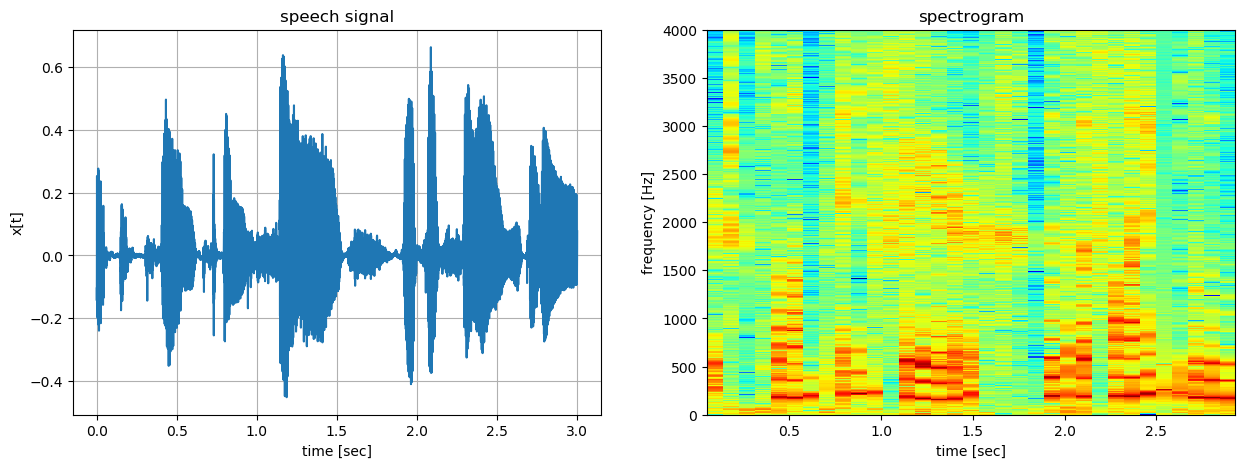

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Generative model

In [5]:
# create factor graphs
fg = FactorGraph()

# AR node
@RV γ ~ ForneyLab.Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV θ ~ GaussianMeanPrecision(placeholder(:μ_θ, dims=(AR_order,)), placeholder(:Λ_θ, dims=(AR_order, AR_order)))
@RV Sprev ~ GaussianMeanPrecision(placeholder(:μ_Sprev, dims=(AR_order,)), placeholder(:Λ_Sprev, dims=(AR_order, AR_order)))
@RV S ~ LAR.Autoregressive(θ, Sprev, γ)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x ~ DotProduct(d, S)
@RV y ~ GaussianMeanPrecision(x, Λ_meas)
placeholder(y, :y)

ForneyLab.draw(fg)
# ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 5687018004626249022 -->
 5687018004626249022 
 
 dot 
 dotproduct_1 
 
<!-- 8133152346533674744 -->
 8133152346533674744 
 
 clamp_1 
 
<!-- 5687018004626249022--8133152346533674744 -->
 5687018004626249022--8133152346533674744 
 
 clamp_1 
 1 out 
 2 in1 
 
<!-- 1198185402705771835 -->
 1198185402705771835 
 
 AR 
 autoregressive_1 
 
<!-- 5687018004626249022--1198185402705771835 -->
 5687018004626249022--1198185402705771835 
 
 S 
 1 y 
 3 in2 
 
<!-- 18143008931636411425 -->
 18143008931636411425 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 4397495298826274891 -->
 4397495298826274891 
 
 placeholder_Λ_Sprev 
 
<!-- 18143008931636411425--4397495298826274891 -->
 18143008931636411425--4397495298826274891 
 
 Λ_Sprev 
 1 out 
 3 w 
 
<!-- 15333305459927228202 -->
 15333305459927228202 
 
 placeholder_μ_Sprev 
 
<!-- 18143008931636411425--15333305459927228202 -->
 18143008931636411425--15333305459927228202 
 
 μ_Sprev 
 1 out 
 2 m 
 
<!-- 8784511730493450725 -->
 8784511730493450725 
 
 placeholder_μ_θ 
 
<!-- 7913116145631358470 -->
 7913116145631358470 
 
 placeholder_y 
 
<!-- 12096088484174851417 -->
 12096088484174851417 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 7913116145631358470--12096088484174851417 -->
 7913116145631358470--12096088484174851417 
 
 y 
 1 out 
 1 out 
 
<!-- 12096088484174851417--5687018004626249022 -->
 12096088484174851417--5687018004626249022 
 
 x 
 1 out 
 2 m 
 
<!-- 1641296005200363583 -->
 1641296005200363583 
 
 clamp_2 
 
<!-- 12096088484174851417--1641296005200363583 -->
 12096088484174851417--1641296005200363583 
 
 clamp_2 
 1 out 
 3 w 
 
<!-- 10152920614859115518 -->
 10152920614859115518 
 
 Gam 
 gamma_1 
 
<!-- 17810255661576690781 -->
 17810255661576690781 
 
 placeholder_b_γ 
 
<!-- 10152920614859115518--17810255661576690781 -->
 10152920614859115518--17810255661576690781 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 3541972247934683130 -->
 3541972247934683130 
 
 placeholder_a_γ 
 
<!-- 10152920614859115518--3541972247934683130 -->
 10152920614859115518--3541972247934683130 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 1202460808672724130 -->
 1202460808672724130 
 
 placeholder_Λ_θ 
 
<!-- 7841792717235621372 -->
 7841792717235621372 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 7841792717235621372--8784511730493450725 -->
 7841792717235621372--8784511730493450725 
 
 μ_θ 
 1 out 
 2 m 
 
<!-- 7841792717235621372--1202460808672724130 -->
 7841792717235621372--1202460808672724130 
 
 Λ_θ 
 1 out 
 3 w 
 
<!-- 1198185402705771835--18143008931636411425 -->
 1198185402705771835--18143008931636411425 
 
 Sprev 
 1 out 
 2 x 
 
<!-- 1198185402705771835--10152920614859115518 -->
 1198185402705771835--10152920614859115518 
 
 γ 
 1 out 
 4 γ 
 
<!-- 1198185402705771835--7841792717235621372 -->
 1198185402705771835--7841792717235621372 
 
 θ 
 1 out 
 3 θ

## Algorithm generation

In [6]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(θ, [S, Sprev], γ, ids=[:θ :S :γ])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorithm
eval(Meta.parse(algo))
println(algo)
;

begin

function stepγ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ]))
messages[2] = ruleSVariationalARIn3PPPN(marginals[:S_Sprev], marginals[:θ], nothing)

marginals[:γ] = messages[1].dist * messages[2].dist

return marginals

end

function stepS!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 6))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:μ_Sprev]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Λ_Sprev]))
messages[2] = ruleSVariationalAROutNPPP(nothing, messages[1], marginals[:θ], marginals[:γ])
messages[3] = ruleSPDotProductOutNPG(nothing, Message(ForneyLab.Multivariate, PointMass, m=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

## Perform inference

In [15]:
# create memory variables
μ_θ_mem = Array{Array{Float64, 1}}(undef, length(x_time))
Λ_θ_mem = Array{Array{Float64, 2}}(undef, length(x_time))
a_γ_mem = Array{Float64}(undef, length(x_time))
b_γ_mem = Array{Float64}(undef, length(x_time))
μ_x_pred = Array{Float64}(undef, length(x_time))
var_x_pred = Array{Float64}(undef, length(x_time))

# set priors
μ_θ_min = randn(AR_order)
Λ_θ_min = 1e-5 * Ic(AR_order)
μ_S_min = zeros(AR_order)
Λ_S_min = 1e-4 * Ic(AR_order)
a_γ_min = 1
b_γ_min = 0.001

# create progress bar
p = Progress(length(x_time), 1, "Observed ")

# create marginals dictionary
marginals = Dict(:θ => vague(GaussianMeanPrecision, AR_order),
                 :γ => vague(Gamma),
                 :Sprev => vague(GaussianMeanPrecision, AR_order))

# create messages array 
messages= Array{Message}(undef, 6)

# loop through samples
for k = 1:length(x_time)
    
    # update progress bar
    update!(p, k)
    
    # update data dictionary
    data = Dict(:y => x_time[k],
                :μ_θ => μ_θ_min,
                :Λ_θ => Λ_θ_min,
                :a_γ => a_γ_min,
                :b_γ => b_γ_min,
                :μ_Sprev => μ_S_min,
                :Λ_Sprev => Λ_S_min)
    
    # get prediction
    stepS!(data, marginals, messages)
    μ_x_pred[k] = ForneyLab.unsafeMean(messages[3].dist)
    var_x_pred[k] = ForneyLab.unsafeVar(messages[3].dist)
    
    # perform variational message passing iterations
    for it = 1:iterations
        stepS!(data, marginals)
        stepγ!(data, marginals)
        stepθ!(data, marginals)
    end
    
    # update priors
    μ_θ_min = ForneyLab.unsafeMean(marginals[:θ])
    Λ_θ_min = ForneyLab.unsafePrecision(marginals[:θ])
    μ_S_min = ForneyLab.unsafeMean(marginals[:S])
    Λ_S_min = ForneyLab.unsafePrecision(marginals[:S])
    a_γ_min = marginals[:γ].params[:a]
    b_γ_min = marginals[:γ].params[:b]
    
    # save infered parameters
    μ_θ_mem[k] = μ_θ_min
    Λ_θ_mem[k] = Λ_θ_min
    a_γ_mem[k] = a_γ_min
    b_γ_mem[k] = b_γ_min
    
end

Observed 100%|██████████████████████████████████████████| Time: 0:09:44


## Predictions

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBAB9e99dwSvvOCzr0Y0K69b3FzvS43ALwLE4A9PwrqPS2aMj5i1Wk+OTqBPi5vcz4LIms+nr0SPofdnDzp1/68xy7UvHWp2705qEe+OFsmvn1Ulr2+b0K9u5EqvdpOhboVHD09fGo4PZfZhjygR428jt9TvbVHgr09r6q9xGHvvQanEL462+y9/NKlvUKogr0qtS+97VHvPH8A6z2nDy0+a0BQPq6/ej4dZoE+mVZ4Po8LJj7Vhh49mJHevFk927zBps69SxBNvhQPQb5tV8K93PdJvZUucb1yrs68ZAMhPdtScj2aZBE9V/o9PJe7jrzOwEW9zzyavaBCy720ZAm+ZtIFvoLa0L09q5u9T9MvvS96HT2vDQk+sAJBPn7zYj4TpYY+TJaNPlDAWT7IHZU9FNb8O8hZEbpm2pm9CmlSvmQjYr40YQa+t8iqvWqMyb1nt469zvPMPBSUrT2LmHk9BNKcPKKDTzzImM48Dx+PvBGavr3cYAW+QgbqvT2b0b1XLdK9wKGpvTpBrLutIrk9gUgiPuJjQD5tzGc+rCCJPoBiej6M0QI+iiNXPDReaTvA/ae8CwgWvsZwdb40wze+9pzcvd9B4b128N29QiUTvd/CBD2nH1M9rgsTPaeHVTww2mA7ortsPB63j7wqI7i9aorUvauXT70Jfd+8Q03xvH55Qz2hYzA+6nhpPsFdaT7KQGw+iXodPgstij0WuUA9UY0TvBSXIL7Hmla+E3sUvik//r2/jSC+DXLxvZ0udrxwSEE9uziEPXhcpz1qNIQ96sMqPfDiNz1F2o08PQSkvZe8Dr6xq9G9i5G5vQeLEb66tAW+e2QPvRwSAD2VrzI99k6vPccDFT77MTE+6tkZPlnF+z0vzsU984ODPelYqTwCeOG8tawmvfsbMr1aWqe9bVbrvStAqr3DyGi9vkmPvcRBhr0KA0u8090dPNbah7zXSgu9XqLQvJMyhLxwj4W80YAsvGh7QDzEEYM9CVYBPr8/Lj7yH0k+M4VxPisqVD5Ul4A9OtEtvOo6ujzopSm9teZUviMqXb6iR8W9f9mxvV7aHL5BZra9Fno+PVGxvD3tBYw9iPCwPTYt+z31OfQ9E4ybPd+lXDxzWhi9DE+AvQTjkL05d+C9QrwKvj49170PI0u9Y0AqvUAdGL0/LQu6J9EtPW4rJz33pcY8xK/FPPeazDzyzqo7Q5/ovEA2EL1Gy8a8in2jvEWD4LwGENO8mgaZvLS0Crt35rM7HrrfOgpbo7sOe5E7Gf/8O2iK2bsS7cC89xiYvBVs0ruoFWi8m8cGvHOuPjwCvr481m6zPHGR+jxvWh09Wl8xPfS6Dz3U+r88ZLyAPA62Rzw+xKU6eNW/vAFEB71i1wG9ti0fvUnDWL2fBzm9FC0QvagbEL1FaAu9xoirvI7zZLzvW1O8M/qju4tkkjuTdxw8Ki2hPAh1HT1R7jA9qvc3Pbfsdj3ryI49OXF0PayLPD0K3AI9MMuvPEC6OLvDNfK832FyvQJ8nr0HUae9xUynvTRgvb0fR7S9wB99vYjmOb1wcha93W2kvIXwkbk1PD88fRHGPGOfAj2SwCM9hymCPXbZuj1dEts94cn7PZaLAT6YF9A9Iw13PcnyNT0wD1274IOWvRPi2r2xGdW9EBIBvksvIb4yNQi+rKS1vetRmr0BGIy98IPjvIWSMDySMbI8DUAAPQPgVz3b35E95U2ePbr8vD0oavY9jrsVPujFIT6SK+k9YLcMPW/EpzyOTA89TmUXvQlVB74QmM69mOhBvW6w0b1hnAq+EJ1ovQLrTTtQ1te8YhFWvLH0XT2muJA9EDIYPUGeGj3+3lc9jiCtPBvftLzV+c6843HavPE1X72BCoq9AMlzvZ3eXL2dlEa937wVvdR8przf7A+8VwspvJZvB7yhbxE4qVgtPFAE+zq/mfm7e74YO4EoszucLvu7jI/nuyQnkjtB+Zi7uHhcvO9ZJ7xtJ+O7DWjlu8ncgbtHNgk7KTV5O/VerzsV8M47xxwLPNcnuTw6ask8xCxxPF9zNTyu+Kg8+TmWPDL7IDwa8GY8EDl9PHm/mDuiTo66VoYSut4TsbvDUta79YXhu7jWyrs4Z8+7yIrPu/0blLqB9xq7AktYOgaDkTsavj87fm0EPF3Tcjx+rvQ7UzMUPL88nTwduFI8W2g/O8vRJTznb5g8eVgrPJamoDtwmIg7pSiNul4WuTsRHS88Sa3Xu3nW/7v1GwU8TOrSO7qLyrukUoo69dVPO5hFIzcqgrw78UVyO0NMbrk2MYc7E/QpPMo3rDvOny06Ii0QPLoXlDurnlg8x4/iO1/7NbkfJqQ8JeAjPJIftTs+YIk8fXbxOn7mxbjL0no8bIPqO1ZzTbwTn5y7LMkYupCtLrwZHBO7CvmKOcMtBryvGMk7SKueu3YYpbw65Cg8YQ2kPACnTbzM7dy8SCQDPN79vTwiN6i8cS6HvORYyzyBu2m8yNWzvOqJ1TyE4Bm7ZwQkvRG92DrCDFE8n1PKvKJU5LxgjoK7pm8DvBMEkLyGdLq7fymbvC2IKrx4yGQ893BIvPbDBr1j+yw8ArTaO6Gay7zyVhO8i9dpO6BdA7zCdIe8F/V5u0Lonzq4VJS8sDF5vKluorvly627c+iPvHQxhbyqJb27mvMhvBN8ArztXLa7wPAJu7Y38LpsjDy7x4ZBu/VTVrhxrPo6JlCdu7cPabsLlqG6UGGtuo0JQLv5ld+7SgeFuwYTkbtDqUK6tByqOVNtcrnvad+5FPxtOwpZg7ls1IW7wCYNuw1BobvTbfa7hMz7u7INz7vljve70kw6vNosB7xij667fGLbuhapVLuj1Da50vDNO0RxvTtDUBI7wgJpO0jYoTtQR+c6hVakOj1uqzp2LSq6q8AXOEQYQ7ofW7O6Z7HUuiwl5LqJfF06rEXFubuDjrvehJS7Kw+6u/Ofy7twMM67rOa5u+Qa+LpN6+W4qQFDO0A6Gzoo2wa4azaOO0kppjsV0Zs6MgGNuqrnTjuC+V07vTzruqMAXrp53187Fq5YO/i9mbkV9QW5kTJhO7gnaDuhfaE7Rte7O4JE9zvSAcQ7chLkO8VBtzucwo47tjWtO5gzQDuZH3E6yflmO034YTtcJts7RtG7O5CIfDtQ9pg78xGVOySSejuRC1c7G+apOzHN6zv6t3E7ZVwvO6fksDtv2Iw7ONLDOxUTITwd8gM8j6SuO7VwxTuYXcM7f9qYOhBgbDvnEPs1iYqDuwksrbsIkaK7wV5Vu2mOk7sRyAK6LFYVOz6UBTrZ9Am4Go6YOm479jm1xUu7F2aku2KQ1btoLfi7m8L1u91uKrwYXki8I1lBvPTzL7xD3Vq8lNQtvACRGLzw4zi8Uec8vJfSO7zA+j682IxqvM3EWbxg83O8ekh0vMDobLxNNF28GpRwvNgRY7xNhQS8fb44vHkXM7yVvxi8joMPvESTELyVYVi8rxNcvA4zZ7ytGUG8FcYzvHmGN7ym2TO8wQoovKDSNrxctEu8J+xFvGPzCrzKCBq8q+ExvEG2CbyRoNK7MA72uyCTortPpnu7RLD2u74Q37va/4W76CtYu26rVru8q4K7OPKau/I8N7qPAee64ClzurKOszmECk84NfDuOrUSQDrinhs5L0AVO+6f77rMY2u7ATunOXInZLmB/0s62PwgOfNScjuqBkM7KHANOxfTqTuG/cc78LurOyswHDwXOOM7LgnbOwpWxTsELLA7G6jgO87dkzvbIvY78Je1O3iDhjvJppM7t/r8O09r6jvDArY7CJANPG47DTwXx6I7F8jVOxyXCjzxgiA85pklPOLZGzzF1w48TqEkPNsgRDyzpw48a/raO1LkDzxfA

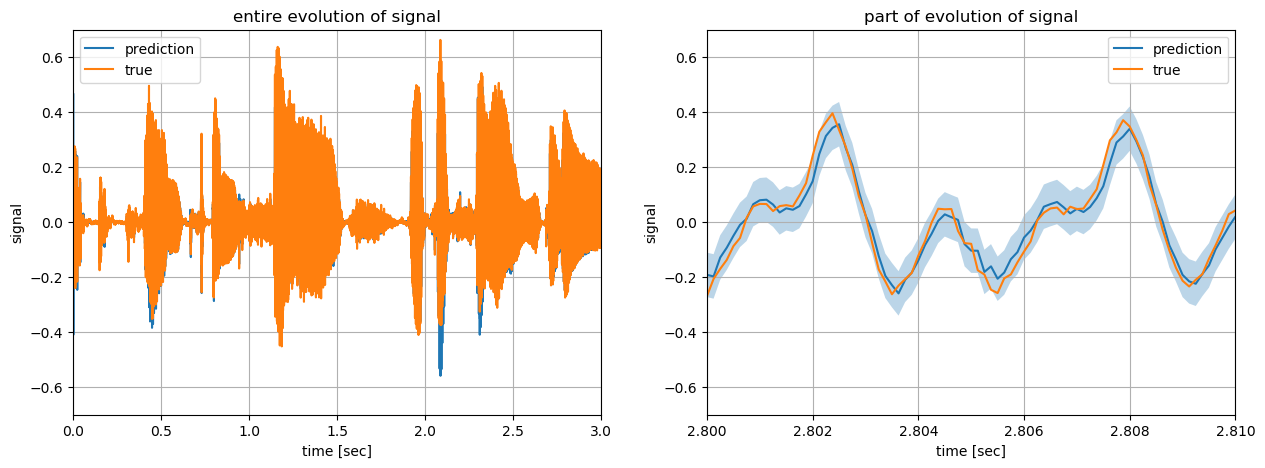

In [23]:
# create figure 
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot prediction of frequency component
ax[1].plot(t, μ_x_pred, label="prediction"), ax[2].plot(t, μ_x_pred, label="prediction")
ax[2].fill_between(t, μ_x_pred .- sqrt.(var_x_pred), μ_x_pred .+ sqrt.(var_x_pred), alpha=0.3)

# plot true evolution of frequency component # add offset because prediction is only performed for second sample forwards
ax[1].plot(t, x_time, label="true"), ax[2].plot(t, x_time, label="true") 

# change visualization
ax[1].legend(), ax[1].grid(), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("signal"), ax[1].set_title("entire evolution of signal"), ax[1].set_xlim(0, 3)
ax[2].legend(), ax[2].grid(), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("signal"), ax[2].set_title("part of evolution of signal")
ax[2].set_xlim(2.8, 2.81), ax[2].set_ylim(-0.7,0.7), ax[1].set_ylim(-0.7, 0.7)

audioplayers(x_time, μ_x_pred, fs=fs_desired)
;

## Visualize parameters

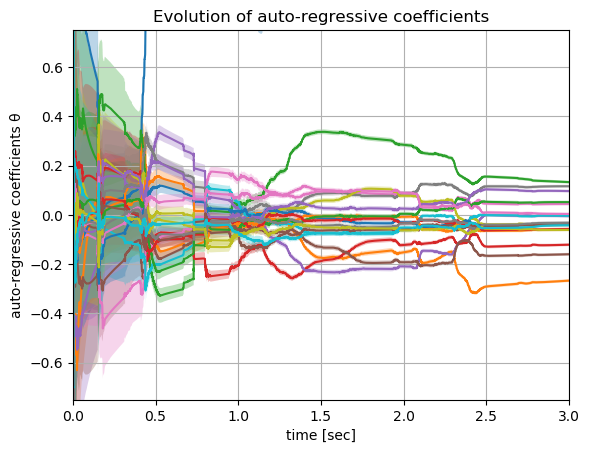

In [17]:
# loop through auto-regressive coefficients
for ki = 1:AR_order
    
    # plot auto-regressive coefficients
    plt.plot(t, [μ_θ_mem[k][ki] for k=1:length(μ_θ_mem)])
    
    plt.fill_between(t, [μ_θ_mem[k][ki] for k=1:length(μ_θ_mem)] .- sqrt.([1/Λ_θ_mem[k][ki,ki] for k=1:length(μ_θ_mem)]), [μ_θ_mem[k][ki] for k=1:length(μ_θ_mem)] .+ sqrt.([1/Λ_θ_mem[k][ki,ki] for k=1:length(μ_θ_mem)]), alpha=0.3)
    
end

# change visualization
plt.grid(), plt.ylim(-0.75, 0.75), plt.xlim(0, 3), plt.xlabel("time [sec]"), plt.ylabel("auto-regressive coefficients θ"), plt.title("Evolution of auto-regressive coefficients")
;

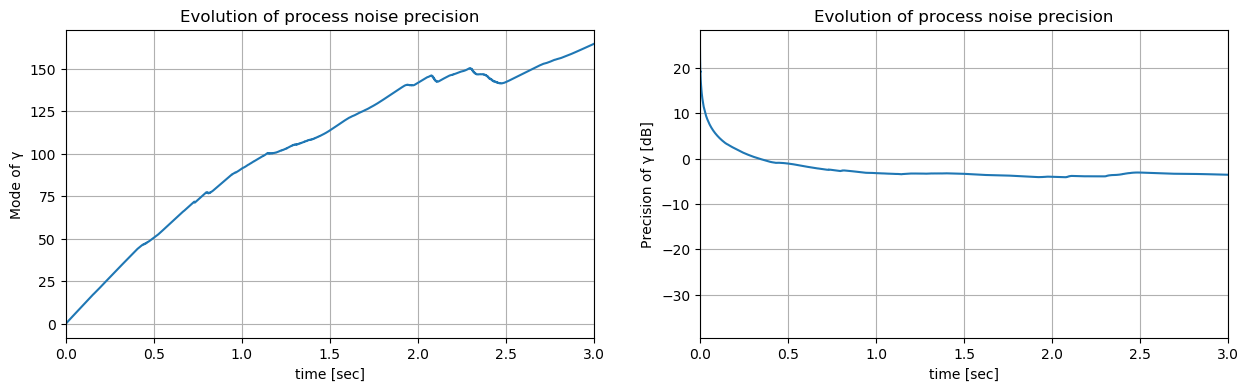

In [18]:
_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[1].plot(t, [(a_γ_mem[k]-1)/b_γ_mem[k] for k = 1:length(a_γ_mem)])
ax[2].plot(t, [10*log10.(b_γ_mem[k]^2/a_γ_mem[k]) for k = 1:length(a_γ_mem)])

# change visualization
ax[1].grid(), ax[1].set_xlim(0, 3), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("Mode of γ"), ax[1].set_title("Evolution of process noise precision")
ax[2].grid(), ax[2].set_xlim(0, 3), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("Precision of γ [dB]"), ax[2].set_title("Evolution of process noise precision")
;

## Plot final spectral estimate

In [19]:
using Distributions
include("visualization.jl")
;

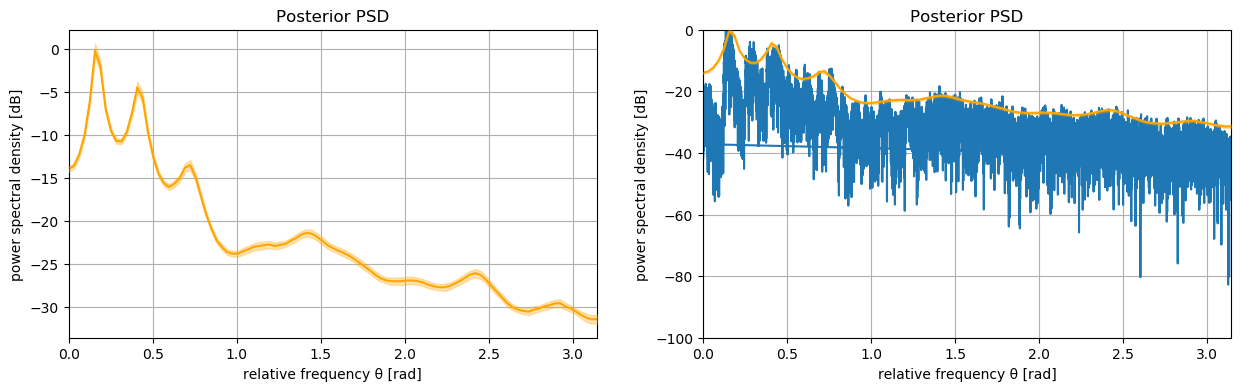

In [20]:
μ_θ_cur = μ_θ_mem[end]
Λ_θ_cur = Λ_θ_mem[end]
a_γ_cur = a_γ_mem[end]
b_γ_cur = b_γ_mem[end]

θ, γ = AR_distributions(μ_θ_cur, Λ_θ_cur, a_γ_cur, b_γ_cur)
mean_psd, std_psd = summary_psd(θ, γ)

_, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[2].plot(FFTW.fftfreq(length(x_time), fs_desired)/fs_desired*2*pi, 10*log10.((abs.(FFTW.fft(x_time)).^2)./length(x_time)))
plot_psd(ax[1], mean_psd, std_psd)
plot_psd(ax[2], mean_psd, std_psd)

ax[1].grid(), ax[1].set_xlabel("relative frequency θ [rad]"), ax[1].set_ylabel("power spectral density [dB]"), ax[1].set_title("Posterior PSD"), ax[1].set_xlim(0, pi)
ax[2].grid(), ax[2].set_xlabel("relative frequency θ [rad]"), ax[2].set_ylabel("power spectral density [dB]"), ax[2].set_title("Posterior PSD"), ax[2].set_xlim(0, pi), ax[2].set_ylim(-100,0)
;

## Save parameters

In [21]:
h5open(savefile, "w") do file
    write(file, "parameters/a_gamma", a_γ_min)
    write(file, "parameters/b_gamma", b_γ_min) 
    write(file, "parameters/mean_theta", μ_θ_min) 
    write(file, "parameters/precision_theta", Λ_θ_min) 
end